In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

data_train = pd.read_csv('data/q1/train.csv')
data_test = pd.read_csv('data/q1/test.csv')
data_validation = pd.read_csv('data/q1/validation.csv')

categorical_cols = data_train.select_dtypes(include='object').columns.tolist()

data_train = pd.get_dummies(data_train, columns=categorical_cols, dtype=int)
data_validation = pd.get_dummies(data_validation, columns=categorical_cols, dtype=int)
data_test = pd.get_dummies(data_test, columns=categorical_cols, dtype=int)

data_test = data_test.reindex(columns=data_train.columns, fill_value=0)
data_validation = data_validation.reindex(columns=data_train.columns, fill_value=0)


X_train = data_train.drop('result', axis=1).values
y_train = data_train['result'].values

X_validation = data_validation.drop('result', axis=1).values
y_validation = data_validation['result'].values

X_test = data_test.drop('result', axis=1).values
y_test = data_test['result'].values

In [27]:
data_validation.describe()

,Unnamed,year,toss,day_match,bat_first,format,fow,score,rpo,result,...,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep
count,870.000000,870.000000,870.000000,870.000000,870.000000,870.000000,870.000000,870.000000,870.000000,870.000000,...,870.000000,870.000000,870.000000,870.000000,870.000000,870.000000,870.000000,870.000000,870.000000,870.000000
mean,4825.489655,2006.104598,0.478161,0.706897,0.487356,0.196552,7.574713,221.468966,5.495460,0.498851,...,0.071264,0.124138,0.122989,0.062069,0.083908,0.127586,0.048276,0.096552,0.091954,0.062069
std,2781.211138,11.778424,0.499810,0.608965,0.500128,0.397619,2.046818,64.785409,1.714046,0.500286,...,0.257414,0.329929,0.328613,0.241420,0.277409,0.333820,0.214472,0.295516,0.289127,0.241420
min,0.000000,1973.000000,0.000000,0.000000,0.000000,0.000000,2.000000,44.000000,1.770000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2493.250000,1998.000000,0.000000,0.000000,0.000000,0.000000,6.000000,171.000000,4.312500,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4764.500000,2008.000000,0.000000,1.000000,0.000000,0.000000,8.000000,219.000000,5.140000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,7295.500000,2016.000000,1.000000,1.000000,1.000000,0.000000,10.000000,266.000000,6.340000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,9655.000000,2023.000000,1.000000,2.000000,1.000000,1.000000,10.000000,439.000000,13.900000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Now the data don't contain any categorical data 

In [29]:
class Node:
    def __init__(self, feature=None, threshold=None, is_leaf=False, target=None):
        self.feature = feature
        self.threshold = threshold
        self.is_leaf = is_leaf
        self.target = target
        self.left = None
        self.right = None


class DecisionTree:
    def __init__(self, max_depth=5, X=None, y=None, feature_names=None):
        self.max_depth = max_depth
        self.X = X
        self.y = y
        self.feature_names = feature_names
        self.root = None

    def calculate_entropy(self, y):
        if len(y) == 0:
            return 0
        p = np.mean(y == 1)
        if p in [0, 1]:
            return 0
        return - (p * math.log2(p) + (1 - p) * math.log2(1 - p))

    def calculate_information_gain(self, X, y, feature_index):
        threshold = np.median(X[:, feature_index])
        left_mask = X[:, feature_index] <= threshold
        right_mask = X[:, feature_index] > threshold

        y_left = y[left_mask]
        y_right = y[right_mask]

        H = (len(y_left)/len(y)) * self.calculate_entropy(y_left) + \
            (len(y_right)/len(y)) * self.calculate_entropy(y_right)
        return self.calculate_entropy(y) - H

    def get_best_split(self, X, y):
        best_gain = 0
        best_feature = None
        for feature_index in range(X.shape[1]):
            gain = self.calculate_information_gain(X, y, feature_index)
            if gain >= best_gain:
                best_gain = gain
                best_feature = feature_index
        return best_feature

    def build_tree(self, X, y, depth):
        if depth == self.max_depth or self.calculate_entropy(y) == 0:
            target = 1 if np.sum(y == 1) >= np.sum(y == 0) else 0
            return Node(is_leaf=True, target=target)

        best_feature = self.get_best_split(X, y)
        root = Node(feature=best_feature)
        root.target = 1 if np.sum(y == 1) >= np.sum(y == 0) else 0

        threshold = np.median(X[:, best_feature])
        left_mask = X[:, best_feature] <= threshold
        right_mask = X[:, best_feature] > threshold

        X_left, y_left = X[left_mask], y[left_mask]
        X_right, y_right = X[right_mask], y[right_mask]

        if len(y_left) == 0:
            target = 1 if np.sum(y == 1) >= np.sum(y == 0) else 0
            child_left = Node(is_leaf=True, target=target)
        else:
            child_left = self.build_tree(X_left, y_left, depth + 1)

        if len(y_right) == 0:
            target = 1 if np.sum(y == 1) >= np.sum(y == 0) else 0
            child_right = Node(is_leaf=True, target=target)
        else:
            child_right = self.build_tree(X_right, y_right, depth + 1)

        root.left = child_left
        root.right = child_right
        root.threshold = threshold
        return root

    def fit(self):
        self.root = self.build_tree(self.X, self.y, 0)

    def predict(self, X):
        y_predictions = []
        for i in range(X.shape[0]):
            current_node = self.root
            while not current_node.is_leaf:
                feature = current_node.feature
                threshold = current_node.threshold
                if X[i, feature] <= threshold:
                    current_node = current_node.left
                else:
                    current_node = current_node.right
            y_predictions.append(current_node.target)
        return np.array(y_predictions)

In [30]:
depth = [15, 25 , 35 , 45]
for dpt in depth:
    

    Dtree = DecisionTree(max_depth=dpt, X=X_train, y=y_train)
    Dtree.fit()

    
    validation_result = Dtree.predict(X_validation)
    test_result = Dtree.predict(X_test)
    train_result = Dtree.predict(X_train)

    
    correct_predictions_validation = np.sum(validation_result == y_validation)
    correct_predictions_test = np.sum(test_result == y_test)
    correct_predictions_train = np.sum(train_result == y_train)

    print(f"Train accuracy for depth {dpt}: {correct_predictions_train / len(y_train) * 100:.2f}%")
    print(f"Validation accuracy for depth {dpt}: {correct_predictions_validation / len(y_validation) * 100:.2f}%")
    print(f"Test accuracy for depth {dpt}: {correct_predictions_test / len(y_test) * 100:.2f}%")

Train accuracy for depth 15: 71.13%
Validation accuracy for depth 15: 57.36%
Test accuracy for depth 15: 56.46%
Train accuracy for depth 25: 84.81%
Validation accuracy for depth 25: 60.11%
Test accuracy for depth 25: 59.05%
Train accuracy for depth 35: 92.41%
Validation accuracy for depth 35: 58.28%
Test accuracy for depth 35: 59.05%
Train accuracy for depth 45: 98.52%
Validation accuracy for depth 45: 58.97%
Test accuracy for depth 45: 60.60%


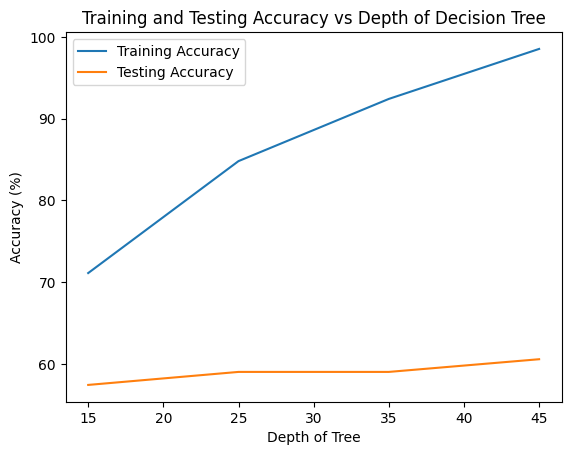

In [2]:
depth = [15, 25 , 35 , 45]
train_acc = [71.13 ,84.81 ,92.41 , 98.52]
# val_acc = [57.36, 60.11 , 58.28 , 58.97]
test_acc = [57.46,59.05,59.05,60.6]

plt.plot(depth, train_acc, label='Training Accuracy')
plt.plot(depth, test_acc, label='Testing Accuracy')
plt.xlabel('Depth of Tree')
plt.ylabel('Accuracy (%)')
plt.title('Training and Testing Accuracy vs Depth of Decision Tree')
plt.legend()
plt.show()